In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF

In [2]:
def get_stats_raw(sample):
    if sample not in ['NA12878', 'NA19238', 'NA19240', 'HG00513', 'HG00514', 
                      'HG00732', 'HG00733', 'HG03486', 'HG02601', 'HG03464']:
        vcf_stats = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/variants/{sample}/vcfstats_{sample}_autosomal.txt', sep = ':', header = None)
    else:
        vcf_stats = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/variants/{sample}/vcfstats_{sample}.txt', sep = ':', header = None)
    vcf_stats[0] = [x.rstrip().lstrip() for x in vcf_stats[0]]
    vcf_stats[1] = [x.rstrip().lstrip() for x in vcf_stats[1]]
    return([vcf_stats[vcf_stats[0] == 'Total Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'SNP Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'Insertion Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'Deletion Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0]])

def get_stats_phased(sample):
    vcf_stats = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/vcfstats_phased_{sample}.txt', sep = ':', header = None)
    vcf_stats[0] = [x.rstrip().lstrip() for x in vcf_stats[0]]
    vcf_stats[1] = [x.rstrip().lstrip() for x in vcf_stats[1]]
    return([vcf_stats[vcf_stats[0] == 'Total Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'SNP Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'Insertion Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0],
            vcf_stats[vcf_stats[0] == 'Deletion Het/Hom ratio'][1].values[0].split('(')[1].split('/')[0]])

In [3]:
def get_number_of_hetvariants_per_chrom_from_hapcut2(sample, chromosome):
    with open(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/hapcut2_{sample}.log', 'r') as f:
        hapcut2_log = f.readlines()
    hapcut2_log = [x for x in hapcut2_log if 'vcffile /DATA/users/m.magnitov/hap_phen/variants/' + sample + '/split/chr' + chromosome + '.vcf' in x]
    hapcut2_log = np.unique(hapcut2_log)[0]
    hapcut2_log = int(hapcut2_log.split('variants')[2].lstrip().rstrip())
    return(hapcut2_log)

def get_chrom_size(chromosome):
    with open(f'/DATA/users/m.magnitov/genomes/refdata-hg38-2.1.0/fasta/genome.dict', 'r') as f:
        chromsizes = f.readlines()
    chromsizes = chromsizes[1:]
    chromnames = [x.split('\t')[1].split(':')[1] for x in chromsizes]
    chromsizes = [int(x.split('\t')[2].split(':')[1]) for x in chromsizes]
    
    chromsizes = pd.DataFrame({'chr': chromnames, 'size': chromsizes})
    
    return(chromsizes[chromsizes['chr'] == 'chr' + chromosome]['size'].values[0])

def get_effective_chrom_size(sample, chromosome):
    vcf = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/variants/{sample}/split/chr{chromosome}.vcf', 
                      comment='#', delim_whitespace = True, header = None)
    return(vcf[1].values[-1]-vcf[1].values[0])

def get_phased_hetvariants_and_span_10x(sample, chromosome):
    vcf = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/10X/{sample}/chr{chromosome}.phased.mvp.VCF', 
                      comment='#', delim_whitespace = True, header = None)
    return(len(vcf), vcf[1].values[-1] - vcf[1].values[0])

def get_phased_hetvariants_and_span_10x_hic(sample, chromosome):
    vcf = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/output/chr{chromosome}.hap.phased.mvp.VCF', 
                      comment='#', delim_whitespace = True, header = None)
    return(len(vcf), vcf[1].values[-1] - vcf[1].values[0])

In [4]:
def get_error_rates(sample, chromosome, variant_type):
    if variant_type != '':
        with open(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/validation/{sample}/hap_stats_chr{chromosome}_{variant_type}.txt', 'r') as f:
            haplotypes_comparison = f.read()
    else:
        with open(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/validation/{sample}/hap_stats_chr{chromosome}.txt', 'r') as f:
            haplotypes_comparison = f.read()
    switch_rate = float(haplotypes_comparison.split('switch rate:')[-1].split('\n')[0].lstrip())
    mismatch_rate = float(haplotypes_comparison.split('mismatch rate:')[-1].split('\n')[0].lstrip())
    return([switch_rate, mismatch_rate])

# Public data

### Phasing statistics

In [5]:
stats_raw, stats_phased = [], []
for sample in ['NA12878', 'HG03486', 'NA20509', 'NA19238', 'NA19239', 'NA19240', 
               'HG00512', 'HG00513', 'HG00514', 'HG00731', 'HG00732', 'HG00733']:
    stats_raw.append(get_stats_raw(sample))
    stats_phased.append(get_stats_phased(sample))
    
stats_raw = pd.DataFrame(stats_raw)
stats_phased = pd.DataFrame(stats_phased)
stats_raw.index = ['NA12878', 'HG03486', 'NA20509', 'NA19238', 'NA19239', 'NA19240', 
                   'HG00512', 'HG00513', 'HG00514', 'HG00731', 'HG00732', 'HG00733']
stats_phased.index = ['NA12878', 'HG03486', 'NA20509', 'NA19238', 'NA19239', 'NA19240', 
                      'HG00512', 'HG00513', 'HG00514', 'HG00731', 'HG00732', 'HG00733']

stats = pd.concat([stats_raw, stats_phased], axis = 1)
stats.columns = ['Total Het', 'SNP Het', 'Insertion Het', 'Deletion Het',
                 'Phased Total Het', 'Phased SNP Het', 'Phased Insertion Het', 'Phased Deletion Het']
for column in stats.columns:
    stats[column] = [int(x) for x in stats[column]]

stats['% Total'] = stats['Phased Total Het']/stats['Total Het']*100
stats['% SNP'] = stats['Phased SNP Het']/stats['SNP Het']*100
stats['% Insertion'] = stats['Phased Insertion Het']/stats['Insertion Het']*100
stats['% Deletion'] = stats['Phased Deletion Het']/stats['Deletion Het']*100

stats = stats[['Total Het', 'Phased Total Het', '% Total', 'SNP Het', 'Phased SNP Het', '% SNP', 
               'Insertion Het', 'Phased Insertion Het', '% Insertion', 'Deletion Het', 'Phased Deletion Het', '% Deletion']]
stats

,Total Het,Phased Total Het,% Total,SNP Het,Phased SNP Het,% SNP,Insertion Het,Phased Insertion Het,% Insertion,Deletion Het,Phased Deletion Het,% Deletion
NA12878,2662453,2654412,99.697985,2218868,2212690,99.721570,216374,215534,99.611783,227211,226188,99.549758
HG03486,3618769,3609940,99.756022,3031262,3024493,99.776694,283093,282248,99.701512,304414,303199,99.600872
NA20509,2597203,2585551,99.551364,2162841,2156202,99.693043,212267,209611,98.748746,222095,219738,98.938742
NA19238,3583426,3565630,99.503380,2993598,2981511,99.596238,285077,282287,99.021317,304751,301832,99.042169
NA19239,3446003,3430102,99.538567,2883574,2872812,99.626783,271911,269443,99.092350,290518,287847,99.080608
NA19240,3574899,3566243,99.757867,2989648,2983160,99.782984,283070,282123,99.665454,302181,300960,99.595938
HG00512,2425395,2413146,99.494969,2019011,2011142,99.610255,198064,195895,98.904899,208320,206109,98.938652
HG00513,2495527,2480863,99.412389,2071868,2063013,99.572608,208004,204946,98.529836,215655,212904,98.724351
HG00514,2469907,2461499,99.659582,2055467,2049207,99.695446,202881,201874,99.503650,211559,210418,99.460671
HG00731,2681644,2667512,99.473010,2235787,2226484,99.583905,217653,215231,98.887220,228204,225797,98.945242


### Fraction of chromosome and variants phased per chromosome

In [16]:
phased_snp_fracs_10X, phased_span_fracs_10X, phased_snp_fracs_HiC_10X, phased_span_fracs_HiC_10X = {}, {}, {}, {}

for sample in ['NA12878', 'HG03486', 'NA20509', 'NA19238', 'NA19239', 'NA19240', 
               'HG00512', 'HG00513', 'HG00514', 'HG00731', 'HG00732', 'HG00733']:

    print('Processing', sample, '...')
    
    if sample in ['NA12878', 'NA19238', 'NA19240', 'HG00513', 'HG00514', 
                  'HG00732', 'HG00733', 'HG03486', 'HG02601', 'HG03464']:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']
    else:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
    
    phased_snp_10X, phased_span_10X, phased_snp_HiC_10X, phased_span_HiC_10X = [], [], [], []
        
    for chromosome in chrom_list:
        
        hetvars = get_number_of_hetvariants_per_chrom_from_hapcut2(sample, chromosome)
        chromsize = get_effective_chrom_size(sample, chromosome)
        
        phased_snps_num, phased_span = get_phased_hetvariants_and_span_10x(sample, chromosome)
        phased_snp_10X.append(phased_snps_num / hetvars)
        phased_span_10X.append(phased_span / chromsize)
        
        phased_snps_num, phased_span = get_phased_hetvariants_and_span_10x_hic(sample, chromosome)
        phased_snp_HiC_10X.append(phased_snps_num / hetvars)
        phased_span_HiC_10X.append(phased_span / chromsize)
    
    phased_snp_fracs_10X[sample] = phased_snp_10X
    phased_span_fracs_10X[sample] = phased_span_10X
    phased_snp_fracs_HiC_10X[sample] = phased_snp_HiC_10X
    phased_span_fracs_HiC_10X[sample] = phased_span_HiC_10X

Processing NA12878 ...
Processing HG03486 ...
Processing NA20509 ...
Processing NA19238 ...
Processing NA19239 ...
Processing NA19240 ...
Processing HG00512 ...
Processing HG00513 ...
Processing HG00514 ...
Processing HG00731 ...
Processing HG00732 ...
Processing HG00733 ...


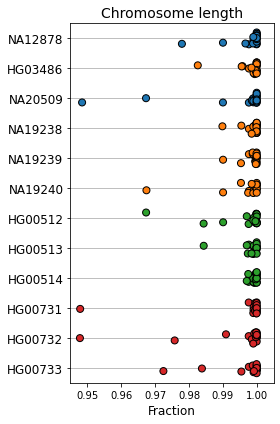

In [11]:
color_palette = ['C0', 'C1', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C3', 'C3']

plt.figure(figsize = (4, 6))
plt.title('Chromosome length', fontsize = 14)
sns.stripplot(data = [phased_span_fracs_HiC_10X['NA12878'],
                      phased_span_fracs_HiC_10X['HG03486'],
                      phased_span_fracs_HiC_10X['NA20509'],
                      phased_span_fracs_HiC_10X['NA19238'],
                      phased_span_fracs_HiC_10X['NA19239'],
                      phased_span_fracs_HiC_10X['NA19240'],
                      phased_span_fracs_HiC_10X['HG00512'],
                      phased_span_fracs_HiC_10X['HG00513'],
                      phased_span_fracs_HiC_10X['HG00514'],
                      phased_span_fracs_HiC_10X['HG00731'],
                      phased_span_fracs_HiC_10X['HG00732'],
                      phased_span_fracs_HiC_10X['HG00733']], 
              jitter = 0.2, orient = 'h', size = 7, edgecolor = 'k', linewidth = 1, palette = color_palette)
plt.xlabel('Fraction', fontsize = 12)
plt.yticks(np.arange(12), list(phased_span_fracs_HiC_10X.keys()), rotation = 0, fontsize = 12)
plt.xlim((0.945, 1.005))
plt.grid(axis = 'y', zorder = 1)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/phasing_public_data_chrom_length.pdf', bbox_inches = 'tight')
plt.show()

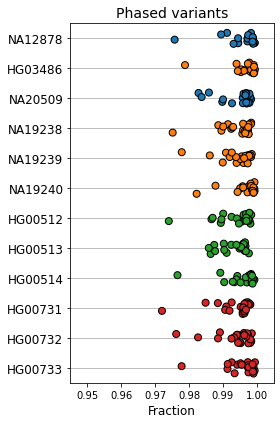

In [12]:
color_palette = ['C0', 'C1', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C3', 'C3']

plt.figure(figsize = (4, 6))
plt.title('Phased variants', fontsize = 14)
sns.stripplot(data = [phased_snp_fracs_HiC_10X['NA12878'],
                      phased_snp_fracs_HiC_10X['HG03486'],
                      phased_snp_fracs_HiC_10X['NA20509'],
                      phased_snp_fracs_HiC_10X['NA19238'],
                      phased_snp_fracs_HiC_10X['NA19239'],
                      phased_snp_fracs_HiC_10X['NA19240'],
                      phased_snp_fracs_HiC_10X['HG00512'],
                      phased_snp_fracs_HiC_10X['HG00513'],
                      phased_snp_fracs_HiC_10X['HG00514'],
                      phased_snp_fracs_HiC_10X['HG00731'],
                      phased_snp_fracs_HiC_10X['HG00732'],
                      phased_snp_fracs_HiC_10X['HG00733']], 
              jitter = 0.2, orient = 'h', size = 7, edgecolor = 'k', linewidth = 1, palette = color_palette)
plt.xlabel('Fraction', fontsize = 12)
plt.yticks(np.arange(12), list(phased_snp_fracs_HiC_10X.keys()), rotation = 0, fontsize = 12)
plt.xlim((0.945, 1.005))
plt.grid(axis = 'y', zorder = 1)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/phasing_public_data_phased_variants.pdf', bbox_inches = 'tight')
plt.show()

### Error rates compared to assembled haplotypes

In [21]:
switch_rates, mismatch_rates = {}, {}

for sample in ['NA12878', 'HG03486', 'NA20509', 'NA19238', 'NA19239', 'NA19240', 
               'HG00512', 'HG00513', 'HG00514', 'HG00731', 'HG00732', 'HG00733']:
    if sample in ['NA12878', 'NA19238', 'NA19240', 'HG00513', 'HG00514', 
                  'HG00732', 'HG00733', 'HG03486', 'HG02601', 'HG03464']:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']
    else:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
    
    sr_sample, mr_sample = [], []
    for chromosome in chrom_list:
        sr, mr = get_error_rates(sample, chromosome, '')
        sr_sample.append(sr)
        mr_sample.append(mr)
        
    switch_rates[sample] = sr_sample
    mismatch_rates[sample] = mr_sample

/tmp/ipykernel_1620576/2589701171.py:5: RuntimeWarning: divide by zero encountered in log10
  sns.stripplot(data = [np.log10(switch_rates['NA12878']),


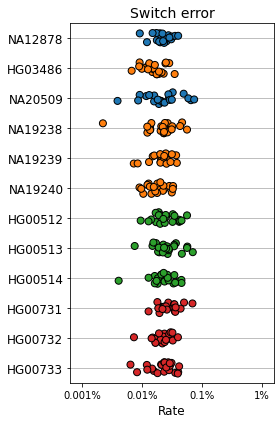

In [14]:
color_palette = ['C0', 'C1', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C3', 'C3']

plt.figure(figsize = (4, 6))
plt.title('Switch error', fontsize = 14)
sns.stripplot(data = [np.log10(switch_rates['NA12878']),
                      np.log10(switch_rates['HG03486']),
                      np.log10(switch_rates['NA20509']),
                      np.log10(switch_rates['NA19238']),
                      np.log10(switch_rates['NA19239']),
                      np.log10(switch_rates['NA19240']),
                      np.log10(switch_rates['HG00512']),
                      np.log10(switch_rates['HG00513']),
                      np.log10(switch_rates['HG00514']),
                      np.log10(switch_rates['HG00731']),
                      np.log10(switch_rates['HG00732']),
                      np.log10(switch_rates['HG00733'])],
              palette = color_palette, jitter = 0.2, size = 7, edgecolor = 'k', linewidth = 1, orient = 'h')
plt.xlabel('Rate', fontsize = 12)
plt.xticks([np.log10(0.00001), np.log10(0.0001), np.log10(0.001), np.log10(0.01)], ['0.001%', '0.01%', '0.1%', '1%'])
plt.yticks(np.arange(12), list(switch_rates.keys()), rotation = 0, fontsize = 12)
plt.xlim((-5.2, -1.8))
plt.grid(axis = 'y', zorder = 1)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/phasing_public_data_switch_error.pdf', bbox_inches = 'tight')
plt.show()

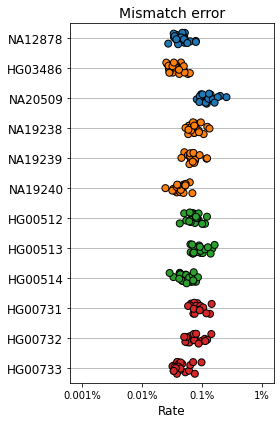

In [15]:
color_palette = ['C0', 'C1', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C3', 'C3']

plt.figure(figsize = (4, 6))
plt.title('Mismatch error', fontsize = 14)
sns.stripplot(data = [np.log10(mismatch_rates['NA12878']),
                      np.log10(mismatch_rates['HG03486']),
                      np.log10(mismatch_rates['NA20509']),
                      np.log10(mismatch_rates['NA19238']),
                      np.log10(mismatch_rates['NA19239']),
                      np.log10(mismatch_rates['NA19240']),
                      np.log10(mismatch_rates['HG00512']),
                      np.log10(mismatch_rates['HG00513']),
                      np.log10(mismatch_rates['HG00514']),
                      np.log10(mismatch_rates['HG00731']),
                      np.log10(mismatch_rates['HG00732']),
                      np.log10(mismatch_rates['HG00733'])],
              palette = color_palette, jitter = 0.2, size = 7, edgecolor = 'k', linewidth = 1, orient = 'h')
plt.xlabel('Rate', fontsize = 12)
plt.xticks([np.log10(0.00001), np.log10(0.0001), np.log10(0.001), np.log10(0.01)], ['0.001%', '0.01%', '0.1%', '1%'])
plt.yticks(np.arange(12), list(mismatch_rates.keys()), rotation = 0, fontsize = 12)
plt.xlim((-5.2, -1.8))
plt.grid(axis = 'y', zorder = 1)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/phasing_public_data_mismatch_error.pdf', bbox_inches = 'tight')
plt.show()

# Our data

### Phasing results

In [6]:
stats_raw, stats_phased = [], []
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    stats_raw.append(get_stats_raw(sample))
    stats_phased.append(get_stats_phased(sample))
    
stats_raw = pd.DataFrame(stats_raw)
stats_phased = pd.DataFrame(stats_phased)
stats_raw.index = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
stats_phased.index = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']

stats = pd.concat([stats_raw, stats_phased], axis = 1)
stats.columns = ['Total Het', 'SNP Het', 'Insertion Het', 'Deletion Het',
                 'Phased Total Het', 'Phased SNP Het', 'Phased Insertion Het', 'Phased Deletion Het']
for column in stats.columns:
    stats[column] = [int(x) for x in stats[column]]

stats['% Total'] = stats['Phased Total Het']/stats['Total Het']*100
stats['% SNP'] = stats['Phased SNP Het']/stats['SNP Het']*100
stats['% Insertion'] = stats['Phased Insertion Het']/stats['Insertion Het']*100
stats['% Deletion'] = stats['Phased Deletion Het']/stats['Deletion Het']*100

stats = stats[['Total Het', 'Phased Total Het', '% Total', 'SNP Het', 'Phased SNP Het', '% SNP', 
               'Insertion Het', 'Phased Insertion Het', '% Insertion', 'Deletion Het', 'Phased Deletion Het', '% Deletion']]
stats

,Total Het,Phased Total Het,% Total,SNP Het,Phased SNP Het,% SNP,Insertion Het,Phased Insertion Het,% Insertion,Deletion Het,Phased Deletion Het,% Deletion
NA12878,2662453,2654412,99.697985,2218868,2212690,99.721570,216374,215534,99.611783,227211,226188,99.549758
NA18983,2412391,2396584,99.344758,2011849,2002726,99.546537,195690,192153,98.192549,204852,201705,98.463769
HG01241,3421113,3403414,99.482654,2859461,2849138,99.638988,272187,268419,98.615658,289465,285857,98.753563
HG02601,2792563,2775867,99.402126,2326130,2316149,99.570918,227958,224473,98.471210,238475,235245,98.645560
HG03464,3645636,3628318,99.524966,3051035,3040529,99.655658,288129,284726,98.818932,306472,303063,98.887663


## Get phasing data for plots

In [7]:
phased_snp_fracs_10X, phased_span_fracs_10X, phased_snp_fracs_HiC_10X, phased_span_fracs_HiC_10X = {}, {}, {}, {}

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    print('Processing', sample, '...')
    
    if sample in ['NA12878', 'HG02601', 'HG03464']:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']
    else:
        chrom_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
                      '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
    
    phased_snp_10X, phased_span_10X, phased_snp_HiC_10X, phased_span_HiC_10X = [], [], [], []
        
    for chromosome in chrom_list:
        
        hetvars = get_number_of_hetvariants_per_chrom_from_hapcut2(sample, chromosome)
        chromsize = get_effective_chrom_size(sample, chromosome)
        
        phased_snps_num, phased_span = get_phased_hetvariants_and_span_10x(sample, chromosome)
        phased_snp_10X.append(phased_snps_num / hetvars)
        phased_span_10X.append(phased_span / chromsize)
        
        phased_snps_num, phased_span = get_phased_hetvariants_and_span_10x_hic(sample, chromosome)
        phased_snp_HiC_10X.append(phased_snps_num / hetvars)
        phased_span_HiC_10X.append(phased_span / chromsize)
    
    phased_snp_fracs_10X[sample] = phased_snp_10X
    phased_span_fracs_10X[sample] = phased_span_10X
    phased_snp_fracs_HiC_10X[sample] = phased_snp_HiC_10X
    phased_span_fracs_HiC_10X[sample] = phased_span_HiC_10X

Processing NA12878 ...
Processing NA18983 ...
Processing HG01241 ...
Processing HG02601 ...
Processing HG03464 ...


## Plots chromosome span and heterozygous variants phased

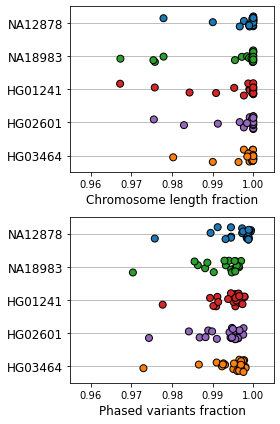

In [19]:
plt.figure(figsize = (4, 6))

plt.subplot(211)
sns.stripplot(data = [phased_span_fracs_HiC_10X['NA12878'],
                      phased_span_fracs_HiC_10X['NA18983'],
                      phased_span_fracs_HiC_10X['HG01241'],
                      phased_span_fracs_HiC_10X['HG02601'],
                      phased_span_fracs_HiC_10X['HG03464']], 
              jitter = 0.2, orient = 'h', size = 7, edgecolor = 'k', linewidth = 1, palette = ['C0', 'C2', 'C3', 'C4', 'C1'])
plt.xlabel('Chromosome length fraction', fontsize = 12)
plt.yticks([0, 1, 2, 3, 4], ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 12)
plt.xlim((0.955, 1.005))
plt.grid(axis = 'y', zorder = 1)

plt.subplot(212)
sns.stripplot(data = [phased_snp_fracs_HiC_10X['NA12878'],
                      phased_snp_fracs_HiC_10X['NA18983'],
                      phased_snp_fracs_HiC_10X['HG01241'],
                      phased_snp_fracs_HiC_10X['HG02601'],
                      phased_snp_fracs_HiC_10X['HG03464']], 
              jitter = 0.2, orient = 'h', size = 7, edgecolor = 'k', linewidth = 1, palette = ['C0', 'C2', 'C3', 'C4', 'C1'])
plt.xlabel('Phased variants fraction', fontsize = 12)
plt.yticks([0, 1, 2, 3, 4], ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 12)
plt.xlim((0.955, 1.005))
plt.grid(axis = 'y', zorder = 1)

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/phasing_chrom_length_and_phased_variants.pdf', bbox_inches = 'tight')
plt.show()